## point-based AMR grid generation

point-based refinement: define starting dimensions and number of coarse cells, then for all cells that satisfy a refinement check, a new grid is added with 2 cells in the new grid

In [1]:
import numpy as np 
import yt 


def grid_dict(le, re, dims, lev, field_dict=None):
    re = np.asarray(re)
    le = np.asarray(le)
    cell_widths = (re - le) / dims
    gd = {
        'left_edge': le, 
        'right_edge': re,             
        "level": lev,
        "dimensions": dims,
        # "cell_widths": cell_widths
    }
    if field_dict is not None:
        for ky, val in field_dict.items():
            gd[ky] = val
    return gd


def get_level_0(domain_left_edge = (0., 0., 0.), 
                domain_right_edge = (1., 1., 1.), 
                level_0_cells = (8, 8, 8),
                field_dict = None
                ):

    domain_left_edge = np.asarray(domain_left_edge)
    domain_right_edge = np.asarray(domain_right_edge)
    level_0_cells = np.asarray(level_0_cells)

    gd = grid_dict(domain_left_edge, domain_right_edge, level_0_cells, 0, field_dict = field_dict)
    grid_list = []
    grid_list.append(gd)
    return grid_list 

def cell_grid_edges_by_dim(le, cell_wids, grid_dims):
    left_edges_by_dim = []
    right_edges_by_dim = []
    for idim in range(3):    
        edges = le[idim] + cell_wids[idim] * (np.cumsum(np.ones((grid_dims[idim]+1,))) - 1)
        left_edges = edges[0:-1]
        right_edges = edges[1:]        
        left_edges_by_dim.append(left_edges)
        right_edges_by_dim.append(right_edges)        
    return left_edges_by_dim, right_edges_by_dim
    
def by_dims_to_list(list_by_dim):
    point_combos = np.meshgrid(*list_by_dim, indexing='ij')
    return np.column_stack([le.ravel() for le in point_combos])


def get_active_grid_cell_edges(le, re, dims):
    cw = (re - le)/dims
    les_by_dim, res_by_dim = cell_grid_edges_by_dim(le, cw, dims)
    left_edges = by_dims_to_list(les_by_dim)
    right_edges = by_dims_to_list(res_by_dim)
    cell_centers = (left_edges + right_edges)/2
    return left_edges, right_edges, cell_centers

def check_refine(cell_centers, current_level, max_level=2):
    if current_level < max_level:
        # arbitrary         
        refine_mask = np.all(cell_centers > 0.4, axis=1)
        refine_mask = np.logical_and(refine_mask, 
                                     np.all(cell_centers < 0.6, axis=1))
        return refine_mask        
    return np.zeros(cell_centers.shape, dtype=bool)
    
    
def _reader(grid ,field):

    # print("wtfffffff")
    # print(grid)
    x = grid.fcoords[:,0].reshape(grid.ActiveDimensions)
    y = grid.fcoords[:,1].reshape(grid.ActiveDimensions)
    z = grid.fcoords[:,2].reshape(grid.ActiveDimensions)
    
    dens = np.random.random(x.shape) * (1.+grid.Level)
    # dens[mask] = 1.0
    return dens


In [2]:
domain_dims = (8, 8, 8)
#flds = {'field0': (_reader, '')}
flds = {'field0': (np.random.random(domain_dims), '')}
grid_data = get_level_0(level_0_cells=domain_dims, field_dict=flds)
ds = yt.load_amr_grids(grid_data, domain_dims)

yt : [INFO     ] 2024-02-05 16:44:55,176 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-02-05 16:44:55,177 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2024-02-05 16:44:55,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-05 16:44:55,178 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-02-05 16:44:55,178 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-02-05 16:44:55,314 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 16:44:55,314 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 16:44:55,316 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 16:44:55,317 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 16:44:55,323 Making a fixed resolution buffer of (('stream', 'field0')) 800 by 800



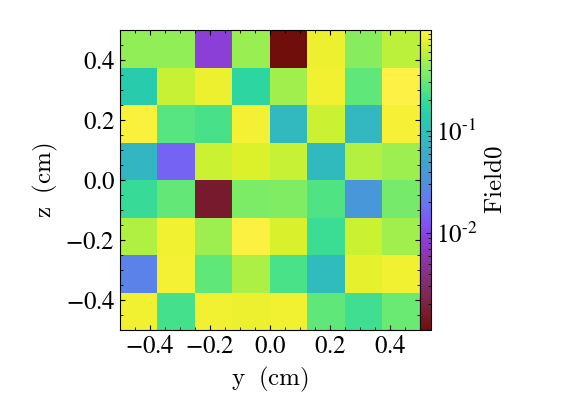

In [3]:
yt.SlicePlot(ds, 'x', ('stream', 'field0'), window_size=(3,3))

In [4]:
domain_dims = (8, 8, 8)
flds = {'field0': (_reader, '')}
grid_data = get_level_0(level_0_cells=domain_dims, field_dict=flds)

gd = grid_data[-1]
le = gd['left_edge']
re = gd['right_edge']
dims = gd["dimensions"]
lev =  gd["level"]
left_edges, right_edges, cell_centers = get_active_grid_cell_edges(le, re, dims)
refine_mask = check_refine(cell_centers, lev)

In [5]:
# splitting individual cells into a new grid, so new dims of
# each grid will be same as the refinement level (default to 2)
new_dims = (2,2,2) 
left_edges = left_edges[refine_mask]
right_edges = right_edges[refine_mask]
new_lev = lev + 1

In [6]:
left_edges = left_edges.tolist()
right_edges = right_edges.tolist()

In [7]:
for gid in range(len(left_edges)):    
    ngd = grid_dict(left_edges[gid], 
                    right_edges[gid], 
                    new_dims, 
                    new_lev, 
                    field_dict=flds)   
    grid_data.append(ngd)

In [8]:
grid_data[1]

{'left_edge': array([0.375, 0.375, 0.375]),
 'right_edge': array([0.5, 0.5, 0.5]),
 'level': 1,
 'dimensions': (2, 2, 2),
 'field0': (<function __main__._reader(grid, field)>, '')}

In [9]:
ds = yt.load_amr_grids(grid_data, domain_dims)

yt : [INFO     ] 2024-02-05 16:44:56,215 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-02-05 16:44:56,216 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2024-02-05 16:44:56,216 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-05 16:44:56,217 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-02-05 16:44:56,217 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-02-05 16:44:56,285 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 16:44:56,285 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 16:44:56,287 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 16:44:56,288 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 16:44:56,289 Making a fixed resolution buffer of (('stream', 'field0')) 800 by 800



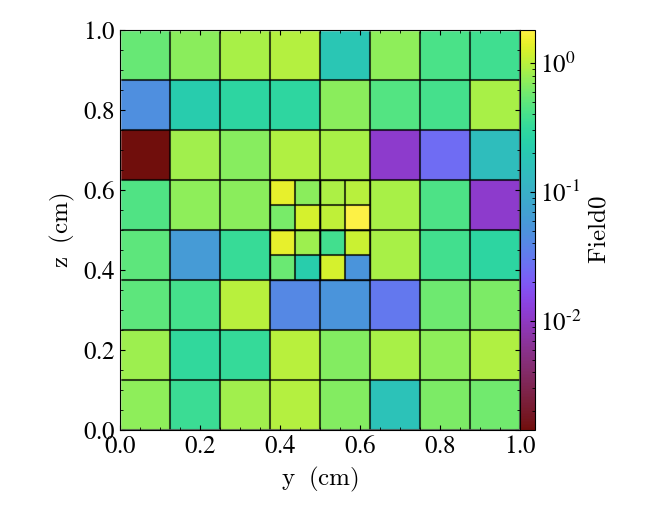

In [10]:
slc = yt.SlicePlot(ds, 'x', ('stream', 'field0'), window_size=(4,4), origin='native')
slc.annotate_grids()
slc.annotate_cell_edges()

In [62]:
def check_refine(cell_centers, current_level, max_level=2):
    if current_level < max_level:
        # arbitrary         
        dist = np.sqrt(np.sum((cell_centers - np.array([0.5, 0.75, 0.75]))**2,axis=1) )
        print(dist.min())
        refine_mask = dist < 0.5 / (current_level + 1)        
        return refine_mask        
    return np.zeros(cell_centers.shape, dtype=bool)

In [71]:
domain_dims = (32, 32, 32)
flds = {'field0': (_reader, '')}
grid_data = get_level_0(level_0_cells=domain_dims, field_dict=flds)

gd = grid_data[-1]
le = gd['left_edge']
re = gd['right_edge']
dims = gd["dimensions"]
lev =  gd["level"]
left_edges, right_edges, cell_centers = get_active_grid_cell_edges(le, re, dims)
refine_mask = check_refine(cell_centers, lev)

0.027063293868263706


In [72]:
# splitting individual cells into a new grid, so new dims of
# each grid will be same as the refinement level (default to 2)

left_edges = left_edges[refine_mask]
right_edges = right_edges[refine_mask]
new_dims = [(2,2,2) for _ in range(len(left_edges))]
new_lev = lev + 1

In [73]:
left_edges = left_edges.tolist()
right_edges = right_edges.tolist()

In [74]:
for gid in range(len(left_edges)):    
    ngd = grid_dict(left_edges[gid], 
                    right_edges[gid], 
                    new_dims[gid], 
                    new_lev, 
                    field_dict=flds)   
    grid_data.append(ngd)

In [75]:
ds = yt.load_amr_grids(grid_data, domain_dims)

yt : [INFO     ] 2024-02-05 17:02:19,386 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-02-05 17:02:19,387 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-02-05 17:02:19,387 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-05 17:02:19,388 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-02-05 17:02:19,388 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-02-05 17:02:20,926 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 17:02:20,927 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 17:02:20,929 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 17:02:20,930 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-05 17:02:20,932 Making a fixed resolution buffer of (('stream', 'field0')) 800 by 800



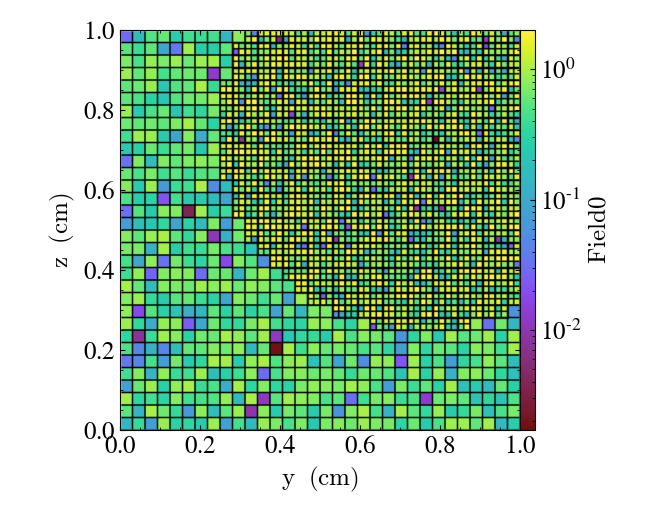

In [76]:
slc = yt.SlicePlot(ds, 'x', ('stream', 'field0'), window_size=(4,4), origin='native')
slc.annotate_grids()
slc.annotate_cell_edges()

routes: 
1. merge adjacent new grids
2. compute level 2 refinement from initial cell center arrays